In [29]:
%matplotlib inline

### Classifying Names with a Character-Level RNN
### Thank you, `Sean Robertson <https://github.com/spro/practical-pytorch>`


In [30]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [31]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [32]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [49]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn2 = RNN(n_letters, n_hidden, n_categories)
rnn3 = RNN(n_letters, n_hidden, n_categories)
rnn4 = RNN(n_letters, n_hidden, n_categories)
rnn5 = RNN(n_letters, n_hidden, n_categories)
rnn6 = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [50]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output3, next_hidden3 = rnn2(input, hidden)
output3, next_hidden3 = rnn3(input, hidden)
output4, next_hidden4 = rnn4(input, hidden)
output5, next_hidden5 = rnn5(input, hidden)
output6, next_hidden6 = rnn6(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [51]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output2, next_hidden2 = rnn(input[0], hidden)
output3, next_hidden3 = rnn(input[0], hidden)
output4, next_hidden4 = rnn(input[0], hidden)
output5, next_hidden5 = rnn(input[0], hidden)
output6, next_hidden6 = rnn(input[0], hidden)
print(output)

tensor([[-2.9625, -2.8938, -2.8366, -2.9496, -2.8289, -2.8190, -2.8582, -2.9916,
         -2.9249, -2.9086, -2.9426, -2.8262, -2.8295, -2.8792, -2.9177, -2.9519,
         -2.8094, -2.9246]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [36]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print (categoryFromOutput(output))

('Korean', 11)


Function to devide data into train and test by 100 * k %

In [56]:
def train_test_split(k, category_lines = category_lines): 
    train_category_lines = {}
    test_category_lines = {}
    for c in all_categories:
        train_category_lines[c] = category_lines[c][:int(len(category_lines[c])*k)]
        test_category_lines[c] = category_lines[c][int(len(category_lines[c])*k):]
    return train_category_lines, test_category_lines
        

We will also want a quick way to get a training example (a name and its
language):




In [54]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(category_lines = category_lines):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

#100 * k % of shuffle in data
def add_noise(k):
    n_data = category_lines
    for c in all_categories:
        for i in range (int(len(n_data[c])*k)):
            n_data[c][random.randint(0, len(n_data[c]) - 1)] = randomChoice(category_lines[all_categories[random.randint(0, len(all_categories) - 1)]]) 
    return n_data
           
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Vasquez
category = Polish / line = Bobienski
category = Czech / line = Sitta
category = Italian / line = Alunni
category = Portuguese / line = Santana
category = Spanish / line = Prieto
category = Czech / line = Fillipova
category = Italian / line = Caito
category = Italian / line = Naggia
category = Italian / line = Piraino


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [55]:
criterion = nn.NLLLoss()
criterion2 = nn.NLLLoss()
criterion3 = nn.NLLLoss()
criterion4 = nn.NLLLoss()
criterion5 = nn.NLLLoss()
criterion6 = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [40]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(rnn, criterion, category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [57]:
import math

# Keep track of losses for plotting
def train_network(k, rnn, criterion, D = category_lines):
    n_iters = 100000
    plot_every = 1000
    current_loss = 0
    all_losses = []
    data = train_test_split(k, D)[0]

    for iter in range(1, n_iters + 1):
    
        category, line, category_tensor, line_tensor = randomTrainingExample(data)
        output, loss = train(rnn, criterion, category_tensor, line_tensor)
        current_loss += loss
       
    # Add current loss avg to list of losses
        if (iter % plot_every) == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses

all_losses = train_network(0.9, rnn, criterion)
all_losses2 = train_network(0.5, rnn2, criterion2)
all_losses3 = train_network(0.7, rnn3, criterion3)

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning with different size of the train data:




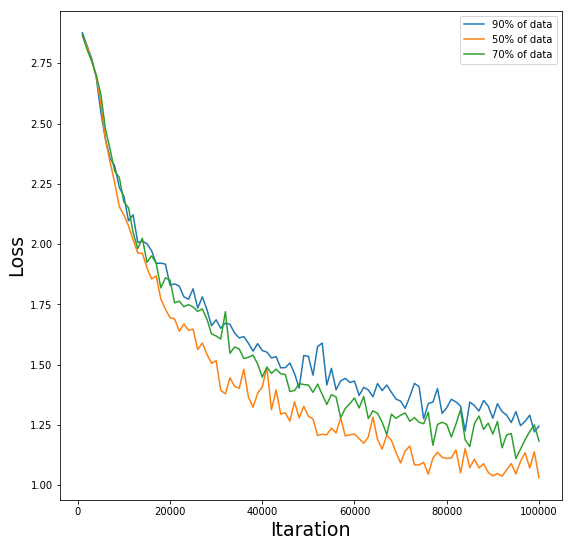

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams["figure.figsize"] = (9,9)

iterations = []
for i in range(1, 101):
    iterations.append(i * 1000)


plt.plot(iterations, all_losses, label = '90% of data')
plt.plot(iterations, all_losses2, label = '50% of data')
plt.plot(iterations, all_losses3, label = '70% of data')
plt.legend()
plt.ylabel('Loss', fontsize=19)
plt.xlabel('Itaration', fontsize=19);

In [58]:
all_losses4 = train_network(0.9, rnn4, criterion4, add_noise(0.01))
all_losses5 = train_network(0.9, rnn5, criterion5, add_noise(0.05))
all_losses6 = train_network(0.9, rnn6, criterion6, add_noise(0.1))

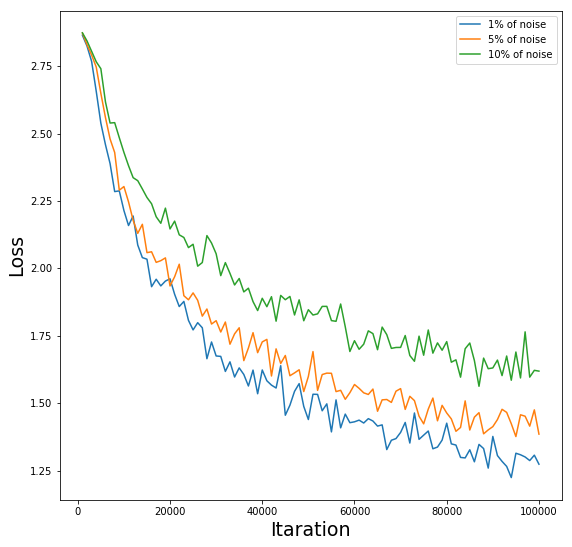

In [59]:
plt.plot(iterations, all_losses4, label = '1% of noise')
plt.plot(iterations, all_losses5, label = '5% of noise')
plt.plot(iterations, all_losses6, label = '10% of noise')
plt.legend()
plt.ylabel('Loss', fontsize=19)
plt.xlabel('Itaration', fontsize=19);

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




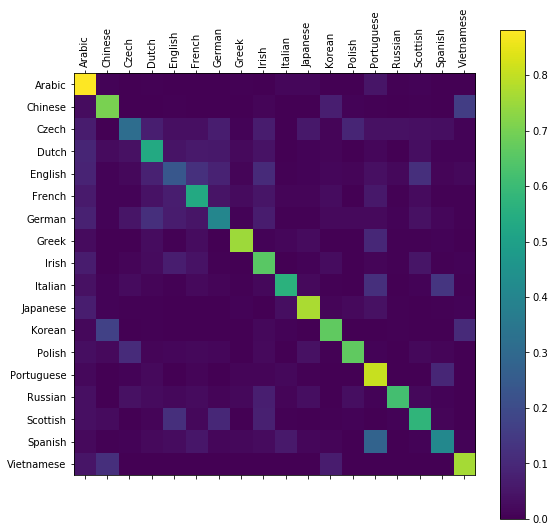

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [47]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Vladimir')
predict('Jonh')
predict('Chan')


> Vladimir
(-0.68) French
(-1.87) Russian
(-2.76) Irish

> Jonh
(-0.20) Korean
(-2.65) Chinese
(-2.99) Vietnamese

> Chan
(-1.37) Irish
(-1.44) Chinese
(-1.51) Arabic
